# Financial Market Simulations With Imitation

This is based on Tedeschi, G., Iori, G. & Gallegati, M. "The role of communication and imitation in limit order markets". Eur. Phys. J. B 71, 489 (2009) [click for link to springer](https://doi.org/10.1140/epjb/e2009-00337-6). For an interactive version of the notebook click on the binder icon:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pjohno/MSc-Math-Finance-Projects/master?filepath=notebooks%2FFinancial%20Markets.ipynb)



In [1]:
#include "msc_project_financialMarkets.hpp"

In [2]:
using namespace MSC_PROJECTS;

First we have created an "Order" type in the code to store information about each order on the market. The order has the following variables:

|Member  | Description   |
|--- |--- |
|oType   | type of order, i.e. bid or ask |
|day     | time period order submitted |
|period  | trading period order submitted |
|price   | price of bid or ask |
|vol     | volume submitted |
|agentID | the unique ID of the agent |


In [3]:
std::cout << "Create a new bid order\n";
// create an order
Order o1;
// give it some values
o1.oType = bid;
o1.day = 0;
o1.period = 1;
o1.price = 100;
o1.vol = 1;
o1.agentID = 0;
    
std::cout << o1 << std::endl;
    
std::cout << "\nCreate some new ask orders\n";
// create another order
Order o2 = { ask , 0 , 2, 104 , 2, 1};
Order o3 = { ask , 1 , 4, 102 , 3, 1};
Order o4 = { ask , 1 , 3, 103 , 4, 1};
Order o5 = { ask , 2 , 3, 100 , 6, 1};
Order o6 = { bid , 3 , 1, 105 , 5, 0};

std::cout << o2 << std::endl;
std::cout << o3 << std::endl;
std::cout << o4 << std::endl;
std::cout << o5 << std::endl;
std::cout << o6 << std::endl;
    

Create a new bid order
 BID  t=0:1 p=100 v=1 agentID=0

Create some new ask orders
 ASK  t=0:2 p=104 v=2 agentID=1
 ASK  t=1:4 p=102 v=3 agentID=1
 ASK  t=1:3 p=103 v=4 agentID=1
 ASK  t=2:3 p=100 v=6 agentID=1
 BID  t=3:1 p=105 v=5 agentID=0


@0x7f2140624ba0

We can now create a set of orders, because of the way the data has been made, this will have the following properties:
 - orders will be ordered by price first, then day then period
 - orders must be unique, so two orders can't be the same

In [4]:
// create an order book for asks
// use a set here since there should only be a single unique order
std::set<Order> askBook;
// now add some ORDERS
askBook.insert(o2);
askBook.insert(o3);
askBook.insert(o4);
askBook.insert(o5);

// Note here
std::cout << "\n\nOutput the ask order book in priority order\n";
{
    int priority=0;
    for(auto o : askBook)
    {
        std::cout << priority<< " :: " << o << std::endl;
        priority++;
    }
}



Output the ask order book in priority order
0 ::  ASK  t=2:3 p=100 v=6 agentID=1
1 ::  ASK  t=1:4 p=102 v=3 agentID=1
2 ::  ASK  t=1:3 p=103 v=4 agentID=1
3 ::  ASK  t=0:2 p=104 v=2 agentID=1


Now consider an agent $A$ in the market. The agent will need to keep track of money, assets and any offers on the market. If we want to build imitation network we also need to track outgoing and incoming links.

|Member | Description |
|--- |--- |
|AgentIndex | unique ID |
|delta | amount of stocks |
|availableDelta  | amount of stocks available |
|cash | amount of cash held in the account |
|availableCash | amount of cash available |
|fitness |  fitness relative to all other agents |
|r | agents estimated return |
|outgoingLink | the identity of the agent that we are following |
|incomingLinks | the identities of the agents that are following us |
|marketOrders | current list of market orders submitted by the agent |

Here the agents wealth $W_t$ at time $t$ is calculated as
$$
W_t = C_t + \Delta_t p_t
$$
where
- $p_t$ is the current market price at time $t$
- $C_t$ is the agents cash at time $t$
- $\Delta_t$ is the number of assets held at time $t$

Notice that we also store information about the agent's cash/assets that are commited inside bids/asks, so denote
$\hat C_t $ as the available cash at time $t$ (so cash minus all bids if they were executed) and $\hat \Delta_t $ as the available assets. 


In [5]:
Agent A;
A.AgentIndex=0;
A.delta = 10;
A.availableDelta = 10;
A.cash = 1000;
A.availableCash = 1000;
std::cout << A;

 Agent:= 0
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 0
 Incoming Links:


Try adding in the offer "o1", we need to adjust available cash/delta according to whether it is a bid/ask.

In [6]:
if(o1.oType== bid)
    A.availableCash=A.availableCash - o1.vol*o1.price;
else
    A.availableDelta= A.availableDelta - o1.vol;
// put it in the market orders
A.marketOrders.insert(o1);
std::cout << A;

 Agent:= 0
 Cash:= 1000 Assets:= 10
 Available Cash:= 900 Available Assets:= 10
 =>  BID  t=0:1 p=100 v=1 agentID=0
 Outgoing Link: =>> 0
 Incoming Links:


We see that after the bid has been made the available cash $\hat \Delta$ is reduced by the amount bid.

Next we move onto making a "Market" containing multiple agents, that can submit bids etc. 

|Member | Description |
|--- |--- |
|MarketPrice | store the current market price |
|guru | the ID of the agent with the most incoming links |
|omega | omega is used to determine the rate at which agents follow other's expectations |
| lambda | the probability of linking to a random agent or the current "guru" |
|rng | random number generator|
|   marketAgents  | store a vector of agents |
|limitOrderBookAsks |  store the limit order book for ask offers |
|limitOrderBookBids | store the limit order book for bid offers |

We need to store the market price $p_t$, as well as other parameters describing the network, suck as the current agent with the most incoming links, or the "guru". 

In [7]:
// setup a new market with 2 agents
Market M(2,10,1000);

The function `printFullMarketData` prints out all information about the market.

In [8]:
M.printFullMarketData();

###############
# MARKET DATA
###############
 Market Price 0
 Guru 0 |  Wealth 1000 | Links 0
#######
# MARKET BIDS
######
#######
# MARKET ASKS
######
#######
# MARKET AGENTS
######
 Agent:= 0
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 0
 Incoming Links:

 Agent:= 1
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 1
 Incoming Links:



The function `submitOrder(const Order &o)` lets you submit an order

In [9]:
M.submitOrder(o1);
M.submitOrder(o2);
M.submitOrder(o3);
M.submitOrder(o4);
M.submitOrder(o5);
M.printFullMarketData();

###############
# MARKET DATA
###############
 Market Price 0
 Guru 0 |  Wealth 1000 | Links 0
#######
# MARKET BIDS
######
 BID  t=0:1 p=100 v=1 agentID=0
#######
# MARKET ASKS
######
 ASK  t=1:4 p=102 v=3 agentID=1
 ASK  t=1:3 p=103 v=4 agentID=1
 ASK  t=0:2 p=104 v=2 agentID=1
#######
# MARKET AGENTS
######
 Agent:= 0
 Cash:= 1000 Assets:= 10
 Available Cash:= 900 Available Assets:= 10
 =>  BID  t=0:1 p=100 v=1 agentID=0
 Outgoing Link: =>> 0
 Incoming Links:

 Agent:= 1
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 1
 =>  ASK  t=1:4 p=102 v=3 agentID=1
 =>  ASK  t=1:3 p=103 v=4 agentID=1
 =>  ASK  t=0:2 p=104 v=2 agentID=1
 Outgoing Link: =>> 1
 Incoming Links:



Now none of these orders match. Add another order we will see it gets executed as a market order. The order is executed at the counterparty price, and completed orders are removed from the agents book as well as the market.

In [10]:
M.submitOrder(o6);
M.printFullMarketData();

###############
# MARKET DATA
###############
 Market Price 103
 Guru 0 |  Wealth 2033 | Links 0
#######
# MARKET BIDS
######
 BID  t=0:1 p=100 v=1 agentID=0
#######
# MARKET ASKS
######
 ASK  t=1:3 p=103 v=2 agentID=1
 ASK  t=0:2 p=104 v=2 agentID=1
#######
# MARKET AGENTS
######
 Agent:= 0
 Cash:= 488 Assets:= 15
 Available Cash:= 388 Available Assets:= 15
 =>  BID  t=0:1 p=100 v=1 agentID=0
 Outgoing Link: =>> 0
 Incoming Links:

 Agent:= 1
 Cash:= 1512 Assets:= 5
 Available Cash:= 1512 Available Assets:= 1
 =>  ASK  t=1:3 p=103 v=2 agentID=1
 =>  ASK  t=0:2 p=104 v=2 agentID=1
 Outgoing Link: =>> 1
 Incoming Links:



In order for the agents to submit orders, we need to let them decide whether they should buy or sell the asset. To do this we use randomisation, where each agent has a random thought about the future price, captured by a normal distribution so that
$$
r^i = \xi^i_r
$$
where
$$
\xi^i_r \sim N(0,\sigma^i).
$$
Each agent $i$ will have their own random thought about the future of the price.

The strategy of the agent updates according to a predicted price $p^*$, which can be calculated from the agents own expectation about the future combined with another agent they follow (denoted as the $j$th agent), so that
$$
p^* = p_t e^{ \omega r^i + (1-\omega) r^j }.
$$
Here the variable $\omega$ is a market variable defining the rate at which agents follow other's expectation.

To implement the strategy, we use this predicted price by saying that if $p^*>p_t$ we think the price is going up and we should buy (submitting a bid order), or $p^*<p_t$ in which case we should sell (submitting an ask order). We then use three random numbers to construct the bid (ask) price and volume, according to the agent's current status.

For instance the bid price is calculated as 
$$
p_\text{bid} = p^*(1-\phi_1)(1-\phi_2) + p_t\phi_2
$$
and ask price is
$$
p_\text{ask} = p^*(1-\phi_2) + p_t(1+\phi_1)\phi_2
$$
and corresponding volume is
$$
v_\text{bid} = \phi_3\frac{\hat{C}}{p_\text{bid}}
$$
or
$$
v_\text{bid} = \phi_3\hat{\Delta}
$$
where
$$
\xi_* \sim U(0,1)
$$

Next we can see an example of the `strategy(int agent,int time,int period)` function. This function create a new random strategy for the `agent` at time `time` and period `period`. This function implements the formulae above.

In [11]:
{
    Order o = M.strategy(0,4,1);
    std::cout << "strategy :: " << o << std::endl;
    M.submitOrder(o);
}
M.printFullMarketData();

strategy ::  ASK  t=4:1 p=123 v=11 agentID=0
###############
# MARKET DATA
###############
 Market Price 103
 Guru 0 |  Wealth 2033 | Links 0
#######
# MARKET BIDS
######
 BID  t=0:1 p=100 v=1 agentID=0
#######
# MARKET ASKS
######
 ASK  t=1:3 p=103 v=2 agentID=1
 ASK  t=0:2 p=104 v=2 agentID=1
 ASK  t=4:1 p=123 v=11 agentID=0
#######
# MARKET AGENTS
######
 Agent:= 0
 Cash:= 488 Assets:= 15
 Available Cash:= 388 Available Assets:= 4
 =>  BID  t=0:1 p=100 v=1 agentID=0
 =>  ASK  t=4:1 p=123 v=11 agentID=0
 Outgoing Link: =>> 0
 Incoming Links:

 Agent:= 1
 Cash:= 1512 Assets:= 5
 Available Cash:= 1512 Available Assets:= 1
 =>  ASK  t=1:3 p=103 v=2 agentID=1
 =>  ASK  t=0:2 p=104 v=2 agentID=1
 Outgoing Link: =>> 1
 Incoming Links:



Now once we need to describe how agents link to each other. Each agent will follow another agent, which we store as the `outgoingLink` for each agent. As the links update or change, we also need to keep track of `incomingLinks`, or the agents that have chosen to follow me. We use a `set` of `int`s to store the incomingLinks, which has a handy `insert` and `erase` function to create or delete links. It also means that you can only link once (as multiple entries not allowed).

New links are created according to some randomisation process, so for each agent we first select a random agent $j$, and noting the current "guru" $j_g$, we choose between linking to a random agent or to the guru according to some variable $\lambda_t$. Let's see how the linking process works, set up a market with 5 agents.

In [12]:
// setup a new market to demonstrate links with 5 agents
Market Mlinks(5,10,1000);

Get the first agent as agent `A`

In [13]:
Agent& A=Mlinks.marketAgents[0];

Find another random agent

In [14]:
// randomly select an agent
std::uniform_int_distribution<> randomAgent(0,Mlinks.size()-1);
int possibleOutgoingLink = randomAgent(Mlinks.rng);
possibleOutgoingLink          

3

Now get the old agent we followed as `oldFollowing`, and remove me from their incoming links with the erase function

In [15]:
Agent& oldFollowing = Mlinks.marketAgents[A.outgoingLink];
oldFollowing.incomingLinks.erase(A.AgentIndex);

Next update my outgoing link to new outgoing link, and get this agent as `newFollowing` and add `A` to their incoming links:

In [16]:
A.outgoingLink = possibleOutgoingLink;
Agent& newFollowing = Mlinks.marketAgents[possibleOutgoingLink];
newFollowing.incomingLinks.insert(A.AgentIndex);

The market should now look like:

In [17]:
Mlinks.printFullMarketData();

###############
# MARKET DATA
###############
 Market Price 0
 Guru 0 |  Wealth 1000 | Links 0
#######
# MARKET BIDS
######
#######
# MARKET ASKS
######
#######
# MARKET AGENTS
######
 Agent:= 0
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 3
 Incoming Links:

 Agent:= 1
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 1
 Incoming Links:

 Agent:= 2
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 2
 Incoming Links:

 Agent:= 3
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 3
 Incoming Links: <<= 0 

 Agent:= 4
 Cash:= 1000 Assets:= 10
 Available Cash:= 1000 Available Assets:= 10
 Outgoing Link: =>> 4
 Incoming Links:



We can see that agent 3 has one incoming link, from agent 0.

Now we can run a simulation with the command `runSimulation(int totalPeriods,int totalIntraPeriods,int tau,double sigma,double A,double sigmaLambda)`, with sigma indicating natural variations in return expectations. 

In [18]:
Mlinks.marketPrice=1000;
Mlinks.omega=1;
Mlinks.lambda=0.;
Mlinks.runSimulation(20,4,1,0.1,1.,0.);

#period  , #marketPrice  , #guru  , #links, #lambda
1 , 1000 , 1 , 2 , 0
2 , 572 , 1 , 2 , 0
3 , 712 , 4 , 2 , 0
4 , 588 , 3 , 2 , 0
5 , 626.5 , 1 , 2 , 0
6 , 585 , 0 , 3 , 0
7 , 538.5 , 0 , 2 , 0
8 , 548.5 , 1 , 2 , 0
9 , 595 , 1 , 2 , 0
10 , 604.5 , 2 , 2 , 0
11 , 529.5 , 0 , 2 , 0
12 , 536.5 , 3 , 2 , 0
13 , 536.5 , 3 , 3 , 0
14 , 458.5 , 2 , 3 , 0
15 , 256 , 2 , 2 , 0
16 , 166.5 , 2 , 2 , 0
17 , 191.5 , 3 , 2 , 0
18 , 171.5 , 1 , 2 , 0
19 , 190 , 0 , 2 , 0
20 , 190 , 3 , 2 , 0



In [19]:
std::ofstream results("results.csv");
Market Mfull(100,100,100000);
Mfull.marketPrice=1000;
Mfull.omega=1;
Mfull.lambda=0.5;

In [20]:
Mfull.runSimulation(200,300,2,0.05,1.,0.1,results);

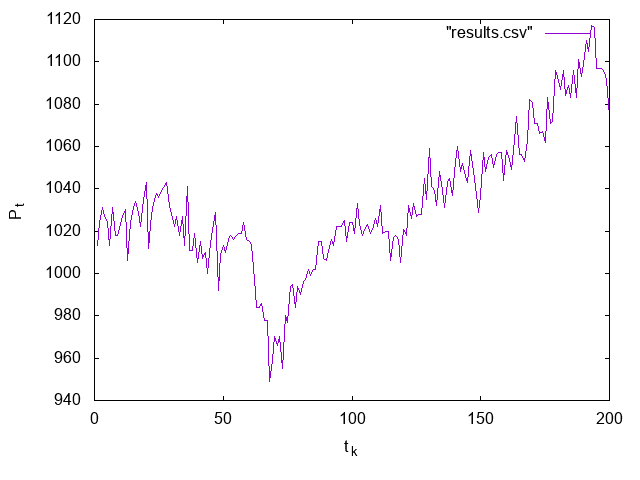

In [21]:
{
    std::stringstream ss("set xrange [0:200]\n"
                        "set xlabel \"t_k\"\n"
                        "set ylabel \"P_t\"\n"
                         "set datafile separator ','\n"
                        "p\"results.csv\" w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

To get a full cpp code implementation in a single file, [click here](https://raw.githubusercontent.com/pjohno/MSc-Math-Finance-Projects/master/main/project-financialMarkets.cpp).

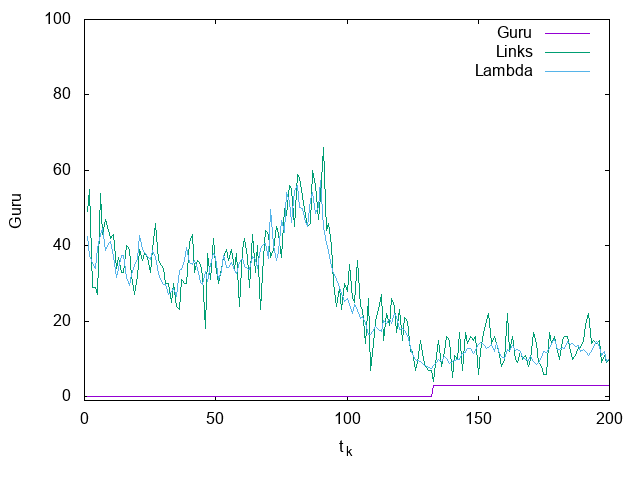

In [22]:
{
    std::stringstream ss("set xrange [0:200]\n"
                         "set yrange [-1:100]\n"
                        "set xlabel \"t_k\"\n"
                        "set ylabel \"Guru\"\n"
                         "set datafile separator ','\n"
                        "p\"results.csv\" u 1:3 ti \"Guru\" w l,\"results.csv\" u 1:4 ti \"Links\" w l,\"results.csv\" u 1:($5*100) ti \"Lambda\" w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure